In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from hyperopt import Trials, tpe, hp, fmin, STATUS_OK
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Download data
train = pd.read_csv('products_sentiment_train.tsv', header=None, sep='\t')
test = pd.read_csv('products_sentiment_test.tsv', sep='\t')
# Set train texts and labels
X_train, y_train = train[0].values, train[1].values
# Set test texts
X_test = test['text'].values

In [3]:
# Pipeline
def text_classifier(vectorizer, classifier):
    return Pipeline([
        ("vct", vectorizer),
        ("clf", classifier)])


# Result dataframe
res = pd.DataFrame(columns=['Id', 'y'])
res['Id'] = test['Id']

# Save function
def to_csv(name, prediction):
    res['y'] = prediction
    res.to_csv('%s.csv'%name, index=False)

Чтобы найти оптимальные гиперпараметры, воспользуемся пакетом *hyperopt*.

Будем использовать следующий **TfidfVectorizer**:

- не будем учитывать стоп слова (*stop_words*)
- analyzer *char_wb*
- би-, три-, четыре- и пятиграммы
- игнорируем слова, которые встретились менее, чем в 25 документах

В качестве классификатора используем **LogisticRegression**:

- C = 10.15387
- penalty = l2
- max_iter = 200

In [4]:
# Обернем нахождение средней точности при кросс-валидации в эту функцию
def hyperopt_train_test(params):
    clf = LogisticRegression()
    vct = TfidfVectorizer(stop_words='english')
    pipe = text_classifier(vct, clf)
    pipe.set_params(**params)
    return np.mean(cross_val_score(pipe, X_train, y_train, cv=5))

# Пространство гиперпараметров
space4log = {
    'vct__ngram_range': hp.choice('ngram_range', [(1,1), (1,2), (2,5)]),
    'vct__analyzer': hp.choice('analyzer', ['word', 'char_wb']),
    'vct__min_df': hp.choice('min_df', [10, 25]),
    'clf__penalty': hp.choice('penalty', ['l1', 'l2']),
    'clf__max_iter': hp.choice('max_iter', [100, 200]),
    'clf__C': hp.uniform('C', 0, 1000)
}

# Функция, которую будем непосредственно оптимизировать
def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4log, algo=tpe.suggest, max_evals=100, trials=trials)
print(best)

100%|██████████| 100/100 [04:36<00:00,  2.77s/trial, best loss: -0.775989437433984]
{'C': 10.153870171874667, 'analyzer': 1, 'max_iter': 0, 'min_df': 1, 'ngram_range': 2, 'penalty': 1}


In [6]:
# Построим классификатор из наилучших гиперпараметров
vct = TfidfVectorizer(stop_words='english', analyzer='char_wb', min_df=25, ngram_range=(2,5))
clf = LogisticRegression(penalty='l2', C=10.1538, max_iter=100)
to_csv('tf', text_classifier(vct, clf).fit(X_train, y_train).predict(test['text']))

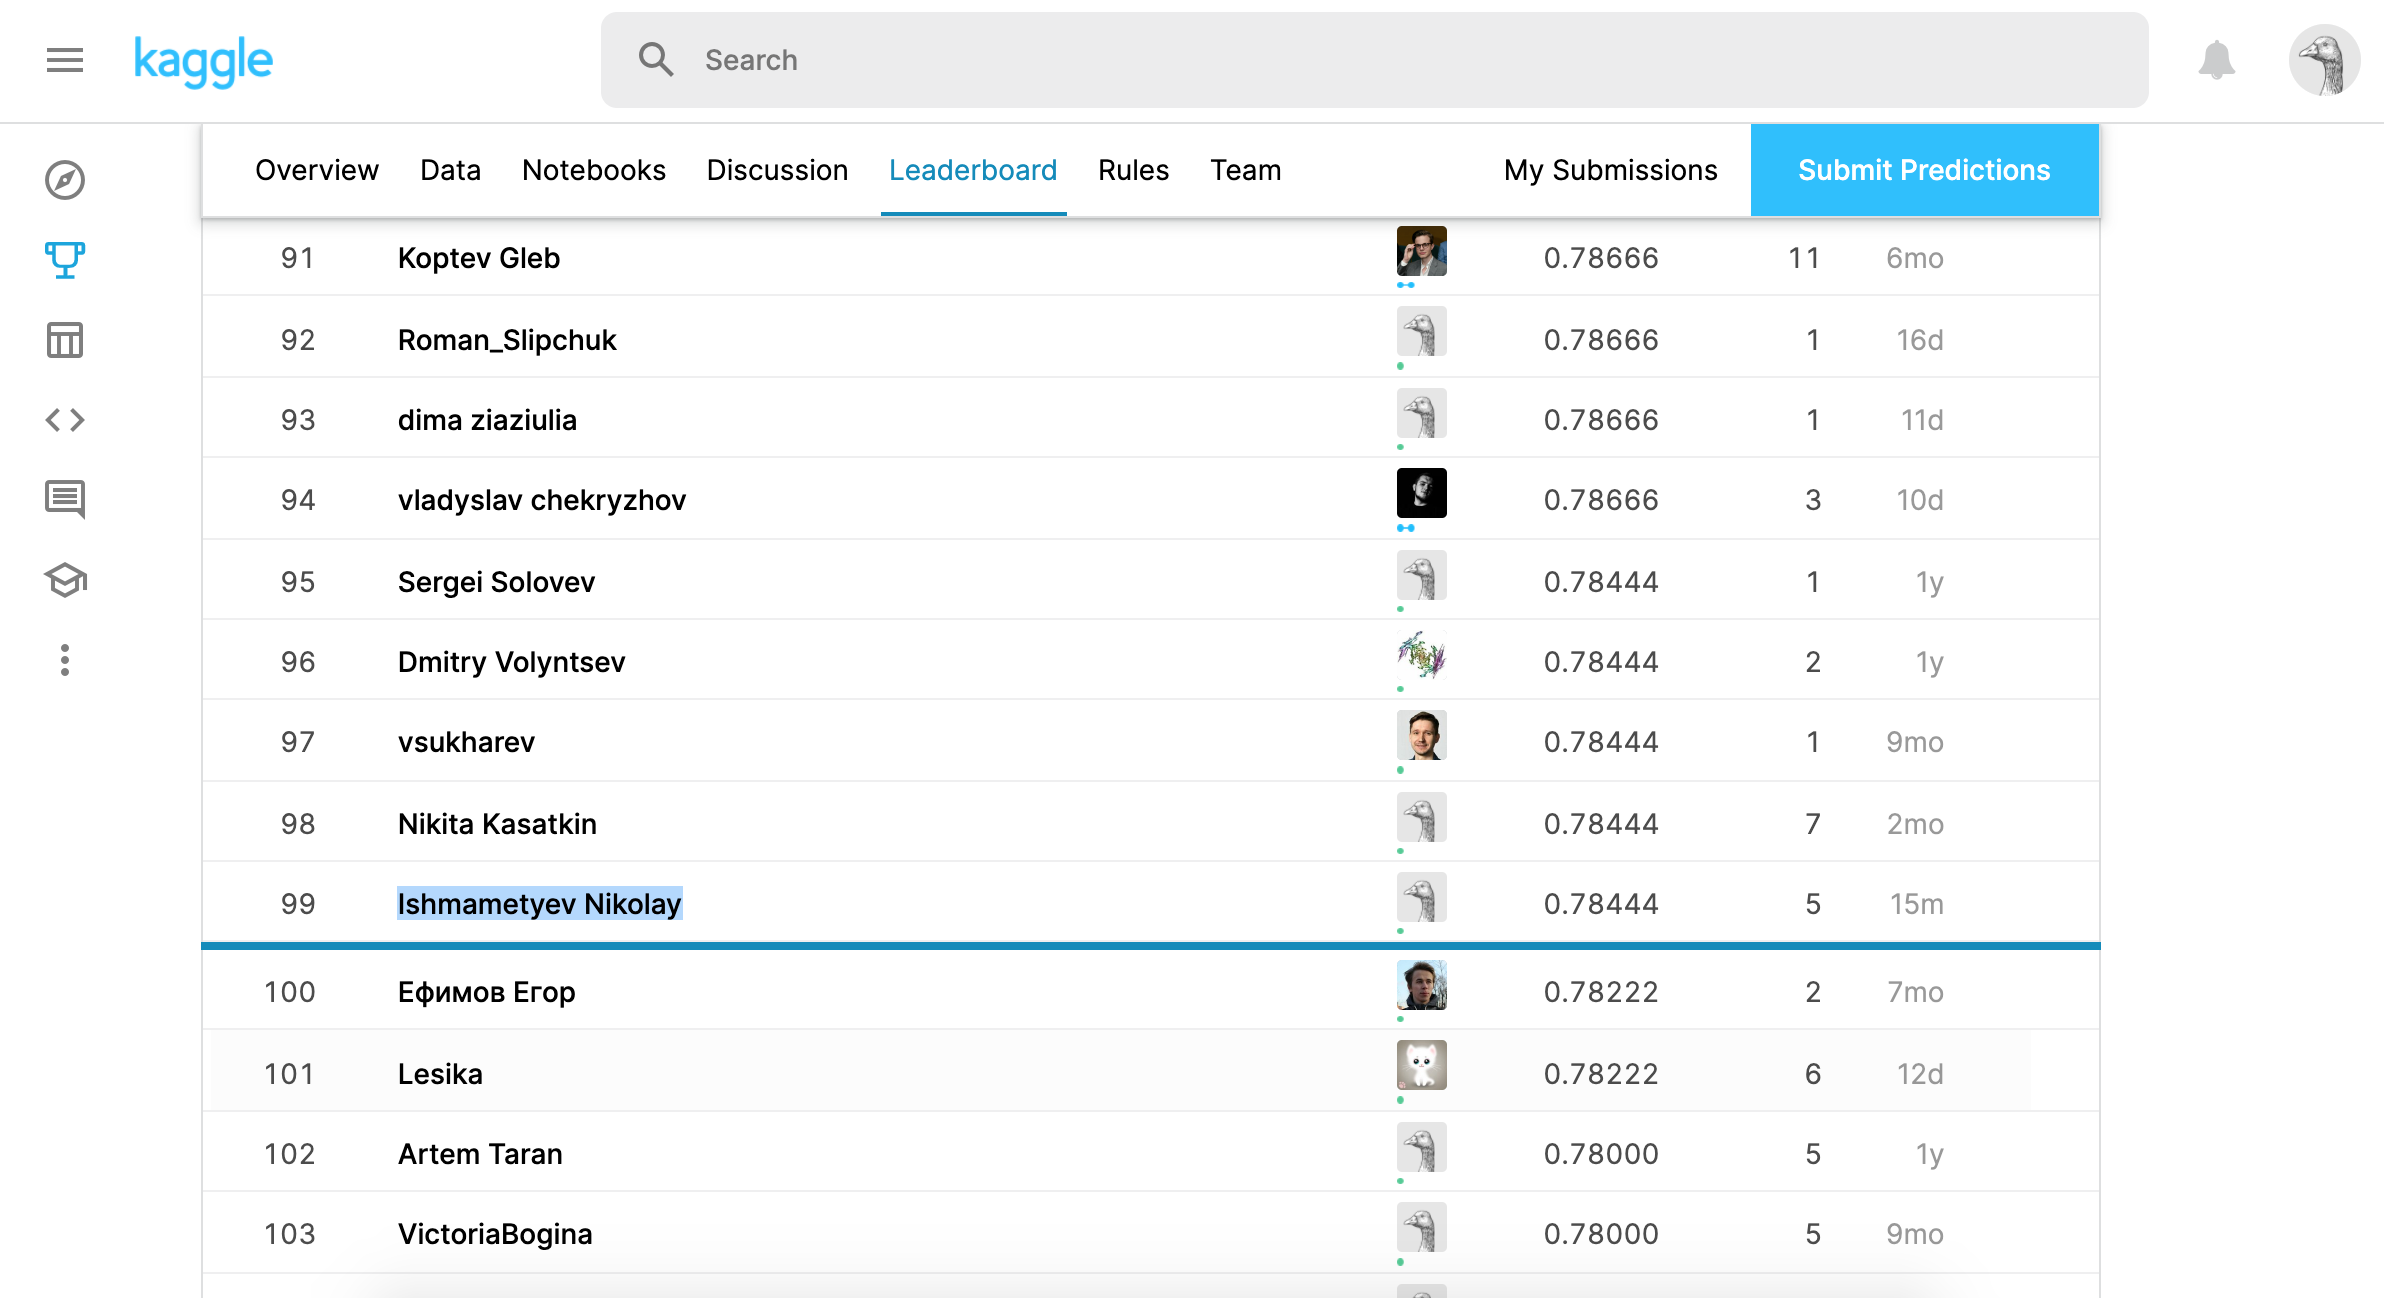

In [7]:
from IPython.display import Image
Image(filename='screen.png') 